# FaceID — Interactive Capture → Analyze (Ask–Capture–Confirm)

This notebook will:
1. **Ask you** when to start.
2. Capture **30** photos (with a short countdown) and save them.
3. **Ask you** to proceed with analysis.
4. Run the **same FaceNet pipeline** and decide **REAL (me)** vs **NOT-ME**, with per-frame CSV + plot.

## Config & Paths


In [ ]:
import os, sys, time, glob, numpy as np

import os, warnings, logging
os.environ["PYTHONWARNINGS"] = "ignore"        # some libs read this
warnings.filterwarnings("ignore")              # silence all warnings
logging.disable(logging.CRITICAL)              # silence all logging

# (optional but tiny) quiet common noisy messages:
warnings.filterwarnings("ignore", message=r"Glyph .* missing from font")

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, "data")
GALLERY_DIR = os.path.join(DATA_DIR, "gallery")
ART_DIR = os.path.join(ROOT_DIR, "artifacts"); os.makedirs(ART_DIR, exist_ok=True)
SESS_ROOT = os.path.join(ROOT_DIR, "captured_sessions"); os.makedirs(SESS_ROOT, exist_ok=True)

DEFAULT_COUNT = int(os.environ.get("CAPTURE_COUNT", "30"))
BASE_THR = float(os.environ.get("BASE_THR", "0.74"))
GAP = float(os.environ.get("GAP", "0.08"))
MIN_BLUR = 35.0
MIN_BRIGHT, MAX_BRIGHT = 60.0, 230.0

print({"DEFAULT_COUNT": DEFAULT_COUNT, "BASE_THR": BASE_THR, "GAP": GAP})
assert os.path.isdir(GALLERY_DIR), f"Gallery not found: {GALLERY_DIR}"

{'DEFAULT_COUNT': 30, 'BASE_THR': 0.74, 'GAP': 0.08}


# Models & Helpers (MTCNN + FaceNet on CPU) 


In [ ]:
import cv2, torch
from PIL import Image, UnidentifiedImageError
from facenet_pytorch import MTCNN, InceptionResnetV1
import numpy as np

DEVICE = "cpu"
torch.set_num_threads(max(1, os.cpu_count()//2))

mtcnn = MTCNN(
    image_size=160, margin=20, min_face_size=40,
    thresholds=[0.6, 0.7, 0.7], factor=0.709,
    keep_all=False, device=DEVICE
)
resnet = InceptionResnetV1(pretrained="vggface2").eval().to(DEVICE)

def _l2n(v: np.ndarray):
    v = v.astype(np.float32)
    n = np.linalg.norm(v) + 1e-12
    return v / n

@torch.no_grad()
def bgr_to_emb(img_bgr):
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    aligned, prob = mtcnn(rgb, return_prob=True)
    if aligned is None:
        return None
    x = aligned.unsqueeze(0).contiguous().to(DEVICE)
    emb = resnet(x).squeeze(0).detach().cpu().numpy()
    return _l2n(emb)

def cosine(a,b): return float(np.dot(a,b))

/Users/vincentgunti/Desktop/FaceID_Practicum/.venv-faceid/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/vincentgunti/Desktop/FaceID_Practicum/.venv-faceid/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Camera & Display (inline-safe for VS Code/Jupyter) 


In [ ]:
import cv2, time
from IPython.display import display, clear_output
from PIL import Image as PILImage

def _find_camera_avfoundation(max_indices=4):
    for idx in range(max_indices):
        cap = cv2.VideoCapture(idx, cv2.CAP_AVFOUNDATION)
        if cap.isOpened():
            ok, frame = cap.read()
            cap.release()
            if ok and frame is not None:
                return idx
    return None

def _inline_show_bgr(bgr, caption=None):
    try:
        import numpy as np
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        pil = PILImage.fromarray(rgb)
        clear_output(wait=True)
        if caption: display(caption)
        display(pil)
    except Exception:
        pass

## FIX CENTROIDS: force rebuild + robust loader 


In [ ]:

import os, glob, numpy as np, cv2

centroids_path = os.path.join(ART_DIR, "gallery.npz")

# 1) Force-delete corrupted centroids (strings inside cause UFuncTypeError)
if os.path.isfile(centroids_path):
    os.remove(centroids_path)
    print("Removed corrupted:", centroids_path)

ALLOWED_EXTS = (".jpg", ".jpeg", ".png")

def _l2n(v: np.ndarray):
    v = v.astype(np.float32)
    n = np.linalg.norm(v) + 1e-12
    return v / n

def _load_images(folder):
    imgs = []
    for p in sorted(glob.glob(os.path.join(folder, "*"))):
        if os.path.splitext(p)[1].lower() not in ALLOWED_EXTS:
            continue
        img = cv2.imread(p, cv2.IMREAD_COLOR)
        if img is not None:
            imgs.append(img)
    return imgs

def _enroll_person(name, images_bgr, min_needed=3):
    embs = []
    for img in images_bgr:
        e = bgr_to_emb(img)
        if e is not None:
            embs.append(e)
    if len(embs) < min_needed:
        raise ValueError(f"{name}: need >= {min_needed} faces, got {len(embs)}")
    embs = np.stack(embs, axis=0)
    centroid = _l2n(embs.mean(axis=0))
    spread = float(np.mean(1.0 - np.clip(embs @ centroid, -1, 1)))
    return {"name": name, "centroid": centroid, "n": len(embs), "spread": spread}

def build_centroids_from_gallery():
    centroids = {}
    persons = [d for d in os.listdir(GALLERY_DIR) if os.path.isdir(os.path.join(GALLERY_DIR, d))]
    persons.sort()
    assert persons, f"No identities under {GALLERY_DIR}"
    for p in persons:
        imgs = _load_images(os.path.join(GALLERY_DIR, p))
        if not imgs:
            print(f"Skip {p}: no JPG/PNG images"); continue
        try:
            entry = _enroll_person(p, imgs)
            centroids[p] = entry["centroid"].astype(np.float32)
            print(f"Enrolled {p}: n={entry['n']} spread={entry['spread']:.4f}")
        except Exception as e:
            print(f"Skip {p}: {e}")
    assert centroids, "No valid identities enrolled."
    np.savez(centroids_path, **centroids)
    print("Saved fresh centroids ->", centroids_path)

def load_centroids_strict():
    """Load and sanity-check numeric 512-d vectors only (no strings)."""
    z = np.load(centroids_path, allow_pickle=False)
    cents = {}
    for k in z.files:
        a = z[k]
        # coerce to float32 and re-normalize
        a = np.asarray(a, dtype=np.float32).reshape(-1)
        if a.shape[0] != 512 or not np.isfinite(a).all():
            print(f"Skip key {k}: invalid shape/dtype"); continue
        cents[k] = _l2n(a)
    assert cents, "No valid centroids after load."
    return cents

# 2) Rebuild and reload
build_centroids_from_gallery()
centroids = load_centroids_strict()

# 3) Make sure your downstream code sees the clean loader
def build_or_load_centroids():
    return load_centroids_strict()

# 4) Pick target (same rule as before)
def pick_target(centroids):
    if "vincent" in centroids:
        return "vincent"
    counts = []
    for d in centroids.keys():
        counts.append((len(glob.glob(os.path.join(GALLERY_DIR, d, '*'))), d))
    counts.sort(reverse=True)
    return counts[0][1]

print("Centroids ready. Target would be:", pick_target(centroids))


Removed corrupted: /Users/vincentgunti/Desktop/FaceID_Practicum/artifacts/gallery.npz
Enrolled Aaron_Peirsol: n=4 spread=0.0942
Enrolled Abdoulaye_Wade: n=4 spread=0.0904
Enrolled Abdullah: n=4 spread=0.0619
Enrolled Abdullah_Gul: n=19 spread=0.1084
Enrolled Abdullah_al-Attiyah: n=3 spread=0.0383
Enrolled Abel_Pacheco: n=4 spread=0.0666
Enrolled Abid_Hamid_Mahmud_Al-Tikriti: n=3 spread=0.0886
Enrolled Adam_Sandler: n=4 spread=0.1203
Enrolled Adel_Al-Jubeir: n=3 spread=0.0398
Enrolled Adolfo_Aguilar_Zinser: n=3 spread=0.0575
Enrolled Adrien_Brody: n=12 spread=0.1068
Enrolled Ahmed_Chalabi: n=5 spread=0.0680
Enrolled Ai_Sugiyama: n=5 spread=0.0601
Enrolled Aicha_El_Ouafi: n=3 spread=0.0554
Enrolled Akbar_Hashemi_Rafsanjani: n=3 spread=0.0772
Enrolled Akhmed_Zakayev: n=3 spread=0.0430
Enrolled Al_Gore: n=8 spread=0.1050
Enrolled Al_Pacino: n=3 spread=0.0553
Enrolled Al_Sharpton: n=7 spread=0.0477
Enrolled Alan_Greenspan: n=5 spread=0.0584
Enrolled Alastair_Campbell: n=5 spread=0.1048
Enro

## Interactive capture (Ask → Countdown → Capture N)

In [ ]:

def capture_session_interactive(n=DEFAULT_COUNT, countdown=3):
    input(f"Ready to take {n} photos? Position your face in good light. Press ENTER to start…")
    cam_index = _find_camera_avfoundation()
    if cam_index is None:
        raise RuntimeError("No working camera. Enable access in System Settings → Privacy & Security → Camera for VS Code/Terminal.")

    cap = cv2.VideoCapture(cam_index, cv2.CAP_AVFOUNDATION)
    if not cap.isOpened():
        raise RuntimeError("Camera opened but not readable. Close Zoom/Meet/FaceTime and retry.")

    # Countdown preview
    for t in range(countdown, 0, -1):
        ok, frame = cap.read()
        if ok and frame is not None:
            _inline_show_bgr(frame, f"Starting in {t}…")
        time.sleep(1.0)

    sess_id = time.strftime("%Y%m%d_%H%M%S")
    sess_dir = os.path.join(SESS_ROOT, f"session_{sess_id}")
    os.makedirs(sess_dir, exist_ok=True)

    kept = 0; attempts = 0; frames = []
    print(f"Capturing up to {n} valid frames… (session: {sess_id})")
    while kept < n and attempts < n*6:
        ok, frame = cap.read(); attempts += 1
        if not ok or frame is None:
            continue
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blur = cv2.Laplacian(gray, cv2.CV_64F).var()
        bright = float(np.mean(gray))
        if blur < MIN_BLUR or not (MIN_BRIGHT <= bright <= MAX_BRIGHT):
            _inline_show_bgr(frame, f"Low quality (blur={blur:.1f}, bright={bright:.0f}) — adjusting…")
            continue
        fpath = os.path.join(sess_dir, f"frame_{kept:03d}.jpg")
        cv2.imwrite(fpath, frame); frames.append(frame); kept += 1
        _inline_show_bgr(frame, f"Saved {kept}/{n}")
    cap.release()
    print("Saved frames to:", sess_dir)
    return sess_dir, frames

## Analysis for a session (Ask to proceed) 

In [ ]:

import csv, matplotlib.pyplot as plt

def analyze_session(session_dir, frames, base_thr=BASE_THR, gap=GAP):
    centroids = build_or_load_centroids()
    target = pick_target(centroids)
    print("Target identity:", target)

    rows = []
    for i, f in enumerate(frames):
        e = bgr_to_emb(f)
        if e is None:
            rows.append([i, "noface", np.nan, np.nan, 0, "REJECT"]); continue
        scores = {name: float(np.dot(e,c)) for name,c in centroids.items()}
        names_sorted = sorted(scores.keys(), key=lambda k: -scores[k])
        best_name = names_sorted[0]
        best = scores[best_name]
        second = scores[names_sorted[1]] if len(names_sorted) > 1 else -1.0
        is_match = (best_name == target) and (best >= base_thr) and ((best - second) >= gap)
        rows.append([i, best_name, best, second, int(is_match), "ACCEPT" if is_match else "REJECT"])

    out_csv = os.path.join(session_dir, "per_frame_scores.csv")
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["frame_idx","pred_name","best_score","second_score","is_match","decision"]); w.writerows(rows)
    print("Wrote:", out_csv)

    accepts = sum(r[4] for r in rows)
    valid_scores = [r[2] for r in rows if isinstance(r[2], float)]
    print(f"Frames: {len(rows)} | ACCEPT (REAL me): {accepts} | REJECT: {len(rows)-accepts}")
    if valid_scores:
        print(f"Score stats — mean={np.nanmean(valid_scores):.3f}  min={np.nanmin(valid_scores):.3f}  max={np.nanmax(valid_scores):.3f}")
    REAL = accepts >= max(1, int(0.6*len(rows)))
    print('FINAL:', '✅ REAL (me)' if REAL else '❌ NOT ME / INCONCLUSIVE')

    # Plot
    if valid_scores:
        plt.figure(figsize=(5,4), dpi=140)
        plt.hist(valid_scores, bins=20, alpha=0.8)
        plt.axvline(base_thr, linestyle='--')
        plt.title(f"Cosine scores vs target='{target}'")
        plt.xlabel("cosine similarity"); plt.ylabel("count")
        out_png = os.path.join(session_dir, "scores_hist.png")
        plt.tight_layout(); plt.savefig(out_png); plt.show()
        print("Saved:", out_png)

def run_interactive(n=DEFAULT_COUNT):
    sess_dir, frames = capture_session_interactive(n=n)
    ans = input("Proceed with analysis now? [Y/n]: ").strip().lower() or "y"
    if ans.startswith("y"):
        analyze_session(sess_dir, frames)
    else:
        print("Okay — analysis skipped. You can run analyze_session(sess_dir, frames) later.")

In [ ]:
# 👉 Run this to start the Ask→Capture→Analyze flow:

print("Ready. To start, run: run_interactive()")

Ready. To start, run: run_interactive()


'Saved 30/30'

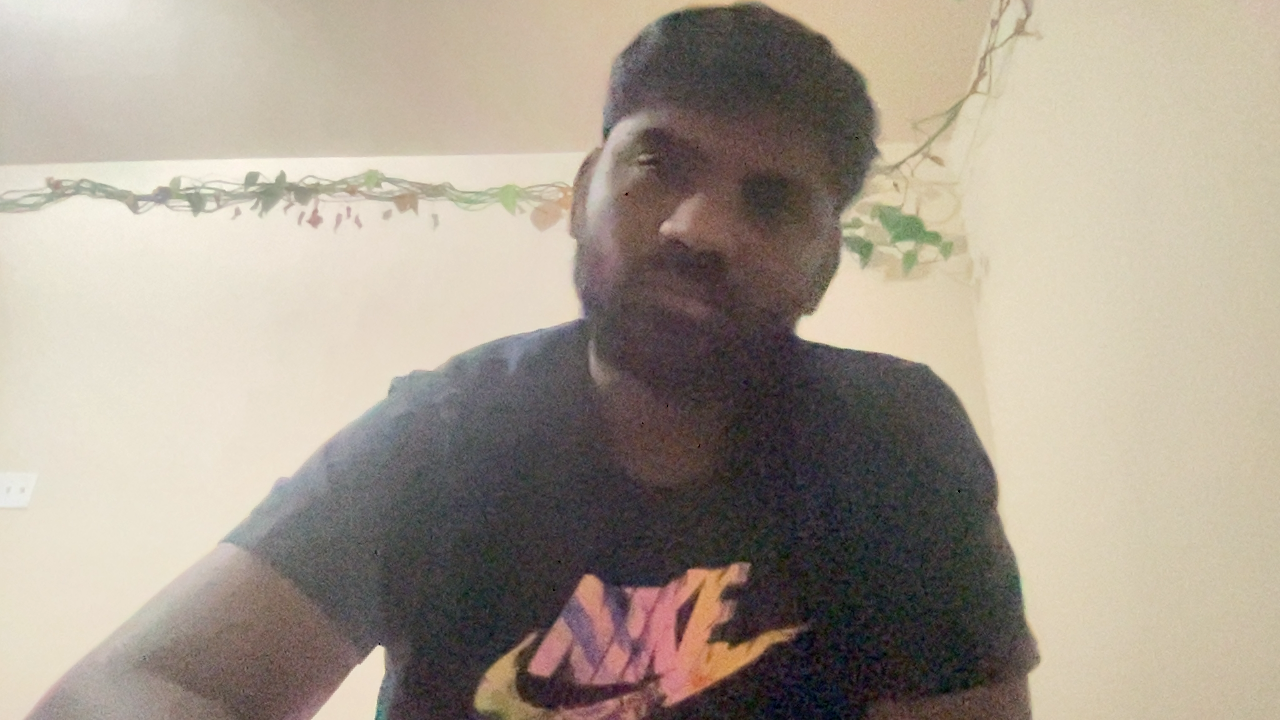

Saved frames to: /Users/vincentgunti/Desktop/FaceID_Practicum/captured_sessions/session_20251019_183752
Target identity: vincent
Wrote: /Users/vincentgunti/Desktop/FaceID_Practicum/captured_sessions/session_20251019_183752/per_frame_scores.csv
Frames: 30 | ACCEPT (REAL me): 19 | REJECT: 11
Score stats — mean=0.756  min=0.652  max=0.844
FINAL: ✅ REAL (me)


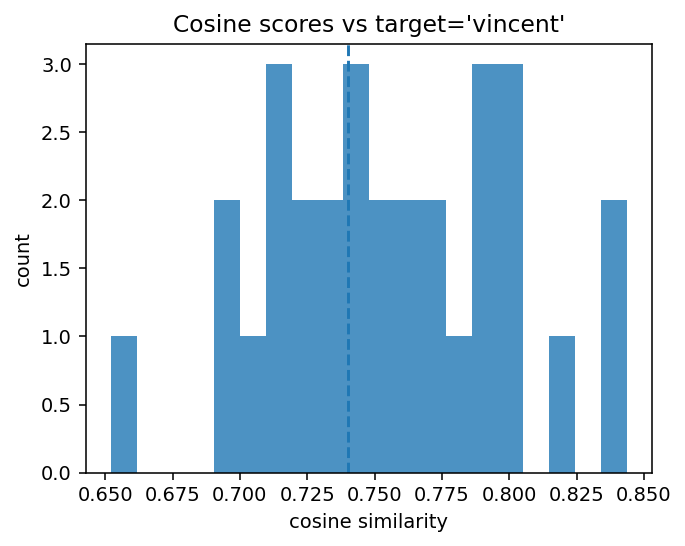

Saved: /Users/vincentgunti/Desktop/FaceID_Practicum/captured_sessions/session_20251019_183752/scores_hist.png


In [8]:
run_interactive()
